# **Finding Lane Lines on the Road** 

***

_In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip_ `P1_example.mp4` _(also contained in this repository) to see what the output should look like._

>**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

I used **region of interest selection, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection**.  The goal was to piece together a pipeline to detect the lines in the image, and draw them onto the image for display (as below).

I didn't need color selection and grayscaling for the pipeline I eventually used.

---

<figure>
 <img src="laneLines_thirdPass.jpg" width="480" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The output image should look like this (more or less) after line detection </p> 
 </figcaption>
</figure>

In [114]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


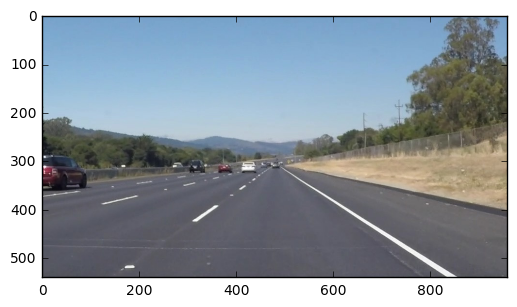

In [115]:
# reading in an image, I made a function from this
def read_img(img_path):
    """reads an image from `img_path`, transforms it into a numpy array.
    
    additionally prints out type and shape information, plus a preview of the image
    returns the image as a numpy array.
    """
    # getting the path of the test images right
    # I had some issues with making sure that I'm on the right path when running anything
    # so I included that part that grounds the `read_img()` function in the directory
    # that holds the notebook file. From there I work forward.
    dir_path = os.path.dirname(os.path.realpath("P1-submit.ipynb"))
    test_dir = dir_path + '/test_images/'
    image = mpimg.imread(test_dir + img_path)
    # printing out some stats and plotting the image
    print('This image is:', type(image), 'with dimesions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

image = read_img('solidWhiteRight.jpg')

**Some OpenCV functions (beyond those introduced in the CarND lesson) that could be useful for this project:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**There's lots of info in the OpenCV documentation**

Below are some provided helper functions to help getting started. Thanks Udacity team! :)

In [116]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Exploring the potential pipeline
Before actually deciding on the pipeline I'll walk through the steps with visual feedback to see which steps are useful and leading me to good results.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


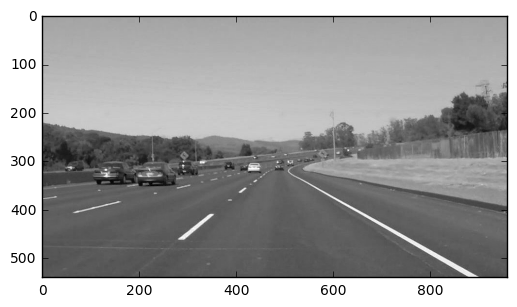

In [117]:
test_image = read_img("solidWhiteCurve.jpg")

gray = grayscale(test_image)
plt.imshow(gray, cmap='gray')

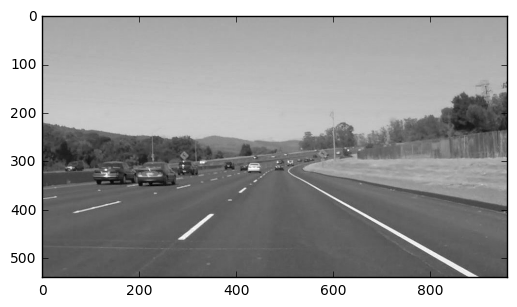

In [118]:
# I had troubles with the color channels differing between the original image and my result after the pipeline
# so here I'm exploring an option to re-establish the 3 channels (even if it doesn't give back color)
backtorgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)
plt.imshow(backtorgb)

In [119]:
# this keeps the image in the same shape as the original one
print(backtorgb.shape)

(540, 960, 3)


(540, 960)


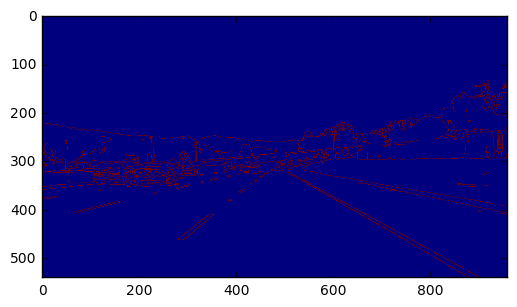

In [120]:
canny_img = canny(test_image, 50, 150) # canny() also discards the channel information!
plt.imshow(canny_img)
print(canny_img.shape)

### REVIEWER QUESTION:
>Why does this show up in red/blue when we discard all color channel information? Why is it not black/white?

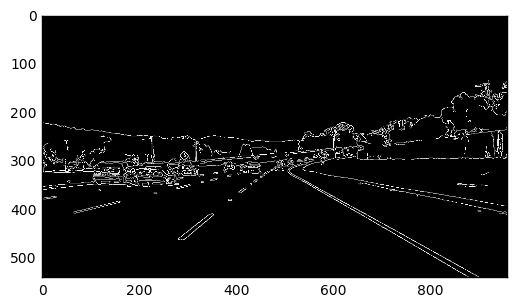

In [121]:
# like this it looks much prettier!
plt.imshow(canny_img, cmap='gray')

(540, 960)


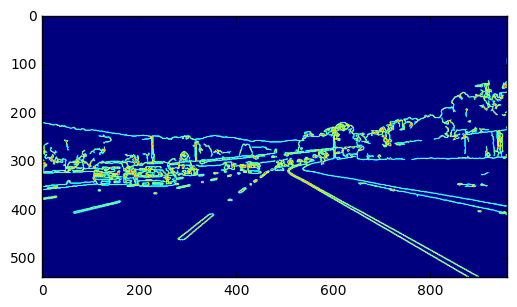

In [122]:
canny_img = gaussian_noise(canny_img, 5)
plt.imshow(canny_img)
print(canny_img.shape)

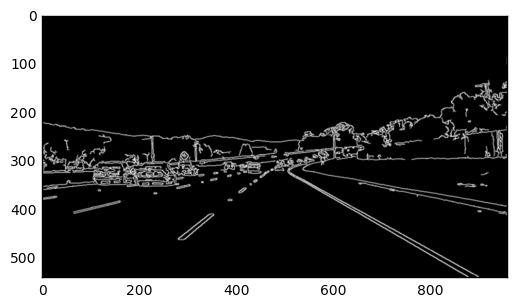

In [123]:
# okay, that one ^ is also kinda cool. But smooth it out grayly, for me:
plt.imshow(canny_img, cmap='gray')

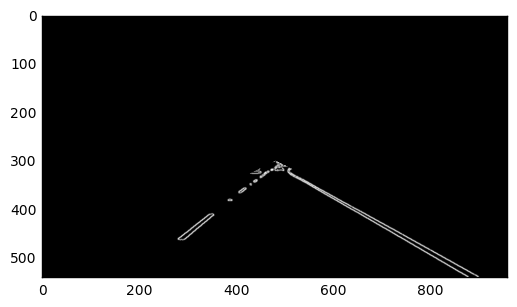

In [124]:
def get_img_h_w(image):
    """extracts height and width in pixel from input image."""
    height = image.shape[0]
    width = image.shape[1]
    return height, width

def define_mask_vertices(image, factor_to_lower_triangle_tip):
    """creates vertices for a mask defining a triangular field of vision.
    
    calls get_img_h_w() on the input image and applies the output to create a triangle
    it also allows for a lowering of the triangle's tip via the factor_to_lower_triangle_tip argument.
    returns the vertices.
    """
    # extracting height and width
    height, width = get_img_h_w(image)
    # defining the vertices for the triangle-of-interest (our blissfully limited field-of-vision)
    vertices = np.array([[(width/2, height/2+factor_to_lower_triangle_tip), (0, height), (width, height), (width/2, height/2+factor_to_lower_triangle_tip)]], dtype=np.int32)
    return vertices

# factor to lower the field of vision below half of the image
lower_triangle_tip = 30

vertices = define_mask_vertices(canny_img, lower_triangle_tip)

#print(vertices)
masked_img = region_of_interest(canny_img, vertices)
plt.imshow(masked_img, cmap='gray')

In [125]:
# until here it works also with re-established 3 color channels
# but because of the next step, I ditched them now already earlier
# (or rather: did not yet re-establish them after Canny)

# keeping 3 channels approach breaks at the next step, because i need a grayscale image for hough_transform:
# https://stackoverflow.com/questions/27014207/failure-to-use-adaptivethreshold-cv-8uc1-in-function-adaptivethreshold

print(masked_img.shape)

(540, 960)


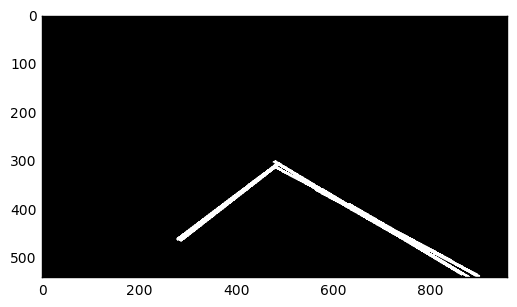

In [126]:
# INPUT FOR FUNCTION: hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
rho = 2 #distance resolution in pixels of the Hough grid
theta = np.pi/180 #angular resolution in radians of the Hough grid
threshold = 200     #minimum number of votes (intersections in Hough grid cell)
min_line_length = 150 #minimum number of pixels making up a line
max_line_gap = 40    #maximum gap in pixels between connectable line segments

hough_img = hough_lines(masked_img, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(hough_img, cmap='gray')

In [127]:
print(test_image.shape)
print(hough_img.shape)
# the unprocessed image has 3 channels, while the processed hough_img does not.
# weighted_img() does not run with the unprocessed image due to this.
# that's why I'm need to re-establish the channels for the transformed image

(540, 960, 3)
(540, 960)


(540, 960, 3)


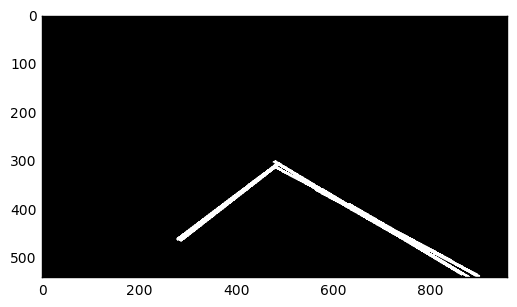

In [128]:
# since `weighted_img()` demands same channel num as original
# I bring it back to 3 channels
hough_img_3chan = cv2.cvtColor(hough_img, cv2.COLOR_GRAY2BGR)
plt.imshow(hough_img_3chan)
print(hough_img_3chan.shape)

### REVIEWER QUESTION:
>I'd be glad if you can give me some tips on how to do this better and draw onto the 3-channel image right away without the detour of transforming once and then back again. Also, this way makes me lose the red of the road lines.

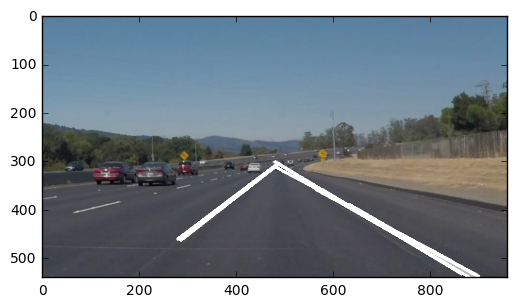

In [129]:
img_applied = weighted_img(hough_img_3chan, test_image, α=0.8, β=1., λ=0.)
plt.imshow(img_applied)

## Creating the pipeline
After going through the process in exploration and being relatively satisfied with the output, I'll create the pipeline for the next step to automate the process across all test images.

In [130]:
def process_image_pipeline(image_path):
    """wrapper function that draws colored lines representing the street markings on input image."""
    test_image = mpimg.imread(str("test_images/") + image_path)
    # creating the grayscale image
    gray = grayscale(test_image)
    # applying canny line detection
    canny_img = canny(test_image, 50, 150) # trying instead of: gray
    # appyling gaussian blur
    canny_img = gaussian_noise(canny_img, 5)
    # calculate vertices for the mask
    vertices = define_mask_vertices(canny_img, 30)
    # apply mask to image
    masked_img = region_of_interest(canny_img, vertices)
    # apply hough line transform
    # hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    # changed max_line_gap to 200 after some test runs
    hough_img = hough_lines(masked_img, 2, np.pi/180, 200, 150, 200)
    # transform image back to BGR-channel info, so that weighted works
    hough_img_3chan = cv2.cvtColor(hough_img, cv2.COLOR_GRAY2BGR)
    # add lines to original image
    img_applied = weighted_img(hough_img_3chan, test_image, α=0.8, β=1., λ=0.) #α=0.8, β=1., λ=0.
    return img_applied

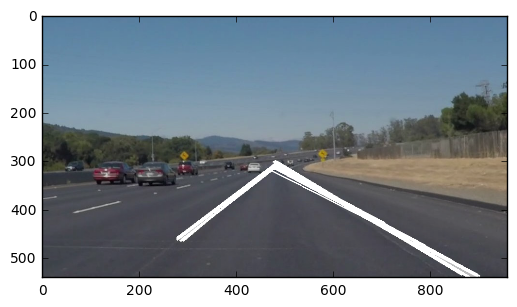

In [131]:
# checking the wrapper function's functionality
pip_image = process_image_pipeline("solidWhiteCurve.jpg")
plt.imshow(pip_image)

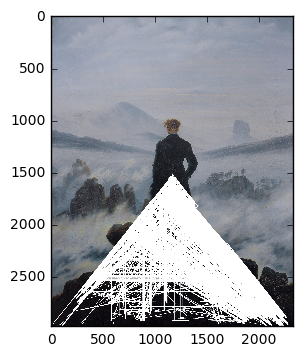

In [132]:
# checking the wrapper function's functionality (haha! ;)
pip_image = process_image_pipeline("wanderer.jpg")
plt.imshow(pip_image)

That one is just a little joke for myself ; )

...

Look how he merged with the mountain!

## Test on Images

In [133]:
import os
os.listdir("test_images/")

['.DS_Store',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'wanderer.jpg',
 'whiteCarLaneSwitch.jpg']

In [134]:
def test_images(list_of_images):
    """Processes all image files in a directory with applying the pipline in `process_image_pipeline()`.
        
    Takes as input a list of strings of image names and returns the processed images as arrays.
    Also writes the processed images to files in the `test_output` folder.
    """
    output_imgs = []
    index = 1
    for img in list_of_images:
        print("processing '{0}' ...".format(img))
        image = process_image_pipeline(img)
        output_imgs.append(image)
        # important to add image extension otherwise it doesn't save the images!!!
        # seen here: https://stackoverflow.com/questions/9868963/cvimwrite-could-not-find-a-writer-for-the-specified-extension
        # (second answer)
        img_name = "test_" + img
        # switching directories to save it separately and avoid collisions
        os.chdir("test_output")
        # http://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#imwrite
        cv2.imwrite(img_name, image)
        # switching back in the directory so that everything's the same for the next round
        os.chdir("..")
        index += 1
    print("Finished execution. Processed and saved {0} images.".format(index))
    # the output does currently not get used, but it might be interesting to keep it around
    return output_imgs

In [135]:
image_list = os.listdir("test_images/")
# deleting .ds_store from the automatically gathered list
if '.DS_Store' in image_list:
    image_list.remove('.DS_Store')
print(image_list)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'wanderer.jpg', 'whiteCarLaneSwitch.jpg']


In [136]:
tested_imgs = test_images(image_list)

processing 'solidWhiteCurve.jpg' ...
processing 'solidWhiteRight.jpg' ...
processing 'solidYellowCurve.jpg' ...
processing 'solidYellowCurve2.jpg' ...
processing 'solidYellowLeft.jpg' ...
processing 'wanderer.jpg' ...
processing 'whiteCarLaneSwitch.jpg' ...
Finished execution. Processed and saved 8 images.


The results of the tests are saved to the `test_output` directory, to keep `test_images` clean.

## Test on Videos

_You know what's cooler than drawing lanes over images? Drawing lanes over video!_

-- Oh dear, yes! :D --

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [137]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [138]:
def process_image(image):
    """wrapper function (pipeline) that draws lines representing the street markings onto input image."""
    # images from the video file come already read-in (as np.arrays - not as filepath strings...)
    # applying canny line detection (also converts to single-channel)
    canny_img = canny(image, 50, 150)
    # appyling gaussian blur
    canny_img = gaussian_noise(canny_img, 5)
    # calculate vertices for the mask
    vertices = define_mask_vertices(canny_img, 30)
    # apply mask to image
    masked_img = region_of_interest(canny_img, vertices)
    # apply hough line transform
    # hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    # changed max_line_gap to 200 (to better connect the broken center-lines)
    # and threshold to 300 after checking with the second video (reducing the number of unwantingly detected lines)
    hough_img = hough_lines(masked_img, 2, np.pi/180, 300, 150, 200)
    # transform image back to BGR-channel info, so that `weighted_img()` works
    hough_img_3chan = cv2.cvtColor(hough_img, cv2.COLOR_GRAY2BGR)
    # add lines to original image
    img_applied = weighted_img(hough_img_3chan, image, α=0.8, β=1., λ=0.) # original: α=0.8, β=1., λ=0.
    return img_applied

Let's try the one with the solid white lane on the right first ...

In [139]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
# checking out some functionalities and structure of my file
print(clip1)
fps = clip1.fps
duration = clip1.duration
num_images = fps * duration
print("There will be {0} images to process in this clip.".format(num_images))

There will be 221.0 images to process in this clip.


In [140]:
# Infos on this magic function
# https://zulko.github.io/moviepy/ref/Clip.html#Clip.Clip.fl
# https://zulko.github.io/moviepy/ref/VideoClip/VideoClip.html?highlight=.fl_image#moviepy.video.VideoClip.VideoClip.fl_image
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:15<00:00, 14.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 9.98 s, sys: 1.46 s, total: 11.4 s
Wall time: 16.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [141]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P0_example1.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

_Now for the one with the solid yellow lane on the left. This one's more tricky!_

### REVIEWER QUESTION:
>It actually seemed to work pretty well for me to simply re-use my original pipeline. I believe this is due to the fact that I mainly worked with masks instead of color recognition. Therefore it doesn't really matter whether the lines are yellow or white. To me this makes sense, but I'm excited to hear your opinion on it!

In [142]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:34<00:00, 19.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 28.8 s, sys: 4.19 s, total: 33 s
Wall time: 35.7 s


In [143]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

### My Process
This project provided a very interesting way to take a first dip into image processing methods and computer vision. The task was to creat good instructions for the computer to be able to correctly identify lane lines.

Initially, I went through the task of applying the different transforms to one of the sample test images. I found it extremely helpful to print each of the results with `plt.imshow()` in order to get a better feel and understanding of what is going on. This already helped me in the exercises of the course material.

Trying different parameter settings and seeing their results immediately makes the task of finding a good selection interactive and motivating.


The three aspects I struggled with the most while working on this project were due to datatypes and the os module:

#### the correct directory
`os.chdir()` is a potentially dangerous thing to evoke, since it well, changes the working directory. This can break code that was working earlier, if there is no switiching back done.

I struggled a bit with keeping track of knowing where I am and when to switch to where (and when back again).
`dir_path = os.path.dirname(os.path.realpath("P1-submit.ipynb"))` helped me to ground myself (`__file__` did not work), and I managed to untangle previously introduced knots from there.

#### the correct file type
The error messages are in my opinion not _completely_ obvious with this library, so it took me a while to figure out that I was passing the wrong _assumption_ into my pipeline.
Coming from the task of setting it up for the test_images (which included loading the image from a file path string), I tried to apply the same concept to the images originating from the `.mp4` files.

However: Error.

Multiple different detours and tries (gleaned from stackoverflow posts) led me astray and around, without really resolving the problem. I did receive changing error messages, though, and when finally realizing that my `read_img()` function was trying to produce a filename _out of a numpy array_ - I understood that this part of the pipeline is superfluos. 

`clip1.fl_image()` already returned its output (each singular image) as an numpy array.
Accounting for this by fixing my pipeline, things finally went well and the lines were drawn onto the video. Yay!

#### channels
`weighted_img()` demands both the input and the transform image to be of the same dimensions. This includes the color channels! When running the previous transforms, already canny edge detection discards the color channels. Therefore the dimensions of the image change from `(540, 960, 3)` to `(540, 960)`. In [a stackoverflow post](https://stackoverflow.com/questions/21596281/how-does-one-convert-a-grayscale-image-to-rgb-in-opencv-python-for-visualizing) I found a solution for how to re-establish 3 channels:

`backtorgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)`

Most of the functions don't complain if they are working with a 3-channel input, however the Hough transform does. It demands a grayscale image.

So it seems to me that the most reasonable approach is to allow Canny to remove the color channels and run the steps until after Hough, then apply the above mentioned `cv2.cvtColor()` transform to re-establish the three channels, and finally combine the two images with `weighted_img()`.

However: That does make my line be white.

I'd be interested if there are better ways to do this, maybe even more obvious ones, since this issue is not mentioned at all in the project description. Maybe it would be good to include a heads-up to clarify this, or make it more obvious where _not_ to stray into the direction I took.

### Potential Issues and Robustifying the pipeline

"Potential" is maybe a little too optimistic, because some of these issues are already here. Let's start with those.

#### camera input
The camera seems to have an issue already in the recording (_or maybe it's a windscreen glare?!_). There is a persistent horizontal line drawn across the image. Since this line is - well - a _line_, the algorithms in the pipeline do recognize it as such and sometimes draw a horizontal line across. I believe that this happens probably when there are subtle changes in the light intensity on the road, which brings the lighter pixels of the camera input issue closer to the color spectrum on the road - and thus the values jump across the threshold and the line gets drawn.

I adapted the threshold to reduce this behaviour, however increasing it too much renders the fragmented center-lines problematic and makes the drawn line flicker there.
The current setting of 300 is therefore a compromise that still keeps the center-line intact, while not introducing too many horizontal lines originating from the camera input problem.

A solution to this would be to have a better camera. :stuck_out_tongue_winking_eye:

But with already present input, it should also be possible to account for a persistent problem e.g. with adapting the mask accordingly. Since the line is always at the same spot, this area could be excluded from being processed.

**How to account for the fact that a camera could start having issues while in a car?**

I think that the algorithm could be made more robust by specifying maybe a certain angle for acceptable lines. However, this could bring problems with, say, STOP lines, so it's probably a bad suggestion. The car should definitely not ignore anything that runs horizontal to its path, since these lines are often extremely important for road safety.

Maybe this could be resolved with specifying the color range of the accepted line inputs. If tweaking the settings in a way that they accept all possible lane color inputs, yet remain blissfully ignorant to other color ranges, then the camera-pixel-error should be ruled out.

If the camera breaks in a way to reproduce exactly that range, well, I guess I'd rather have it compute that it's a STOP sign and stop, than having it eventually drive across one of those...

#### color changes on the road surface
As nicely exemplyfied with the third video, fixed road pieces of different color can create confusion (there's a clear horizontal line to find when one surface changes to another, with all the issues mentioned above).

And secondly, probably even more common: **shadows**.
These also represent clear lines that will necessarily be recognized by such a simple edge detection algorithm as mine.

Since the pixel-intensity-difference would still remain quite large even after discarding color information, there must be a different way to solve this.

I would say that the `cv2.line()` function could be interesting for this. Maybe it's possible to define endpoints for line segments and connect only those.

I'm always though confused about the fact that there are also legitimate horizontal lines on roads, and how to distinguish one from the other.

### REVIEWER QUESTION:
>Yeah! How can you do this?! ^ : )

## Optional Challenge

I enjoyed having the optional challenge around. It was for me very useful already just to see how easily this pipeline can break...

I did not attempt to solve it as of now, but will be coming back to this with a little more knowledge : )

In [144]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:37<00:00,  8.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 32.6 s, sys: 2.74 s, total: 35.3 s
Wall time: 39.8 s


In [145]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

Messy!!!! Shadow comes, total line-party... Road segment changes, flickering all over... Haha! Ajaja, lots to learn! : D

### REVIEWER QUESTION:
>Any tips? : )